# Data preparation

* From **business understanding**, we know the task to be solved.  
* Then we do **data understanding** to look into data.
* Now we are going to do some necessary or useful data transformation to reach the aim.

## Outline
0. Summary of data understanding
1. Missing and invalid data
2. Making different entities
3. Mathematical transformation
4. Feature extraction

## Data and tasks
* Titanic2 - data preparation for an analysis of ticket fares
* Home Credit - segmentation of clients by family situation

In [196]:
# setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.precision", 2)
plt.rcParams['figure.figsize'] = [8, 6]
sns.set_theme(style="ticks", color_codes=True)

In [197]:
# data reading
df1 = pd.read_csv('titanic_train.csv')

## Titanic and ticket fares
### Summary of data understanding
Just few facts from the exploration -- for the aim of this practice.

Let's consider these columns only: *pclass*, *sex*, *age*, *ticket*, *fare*, *cabin*, *embarked*

In [198]:
df1 = df1[['passenger_id', 'ticket', 'pclass', 'fare', 'sex', 'age', 'cabin', 'embarked']]
df1

,passenger_id,ticket,pclass,fare,sex,age,cabin,embarked
0,1216,335432,3,7.73,female,NaN,NaN,Q
1,699,315089,3,8.66,male,38.0,NaN,S
2,1267,345773,3,24.15,female,30.0,NaN,S
3,449,29105,2,23.00,female,54.0,NaN,S
4,576,28221,2,13.00,male,40.0,NaN,S
...,...,...,...,...,...,...,...,...
845,158,680,1,50.00,male,55.0,C39,S
846,174,11771,1,29.70,male,58.0,B37,C
847,467,244367,2,26.00,female,24.0,NaN,S
848,1112,SOTON/O.Q. 3101315,3,13.78,female,3.0,NaN,S


In [199]:
# missing data (NaN, NULL) in %
100 - df1.count() / df1.shape[0] * 100

passenger_id     0.00
ticket           0.00
pclass           0.00
fare             0.12
sex              0.00
age             20.47
cabin           77.53
embarked         0.12
dtype: float64

* *ticket*, *pclass* and *sex* are complete
* *fare* and *embarked* have negligible counts of missing data
* *age* and *cabin* have significant counts of missing data

In [200]:
# invalid values in data?
# frequency tables of categorical columns
print(df1['pclass'].value_counts())
print(df1['sex'].value_counts())
print(df1['embarked'].value_counts())
# the most often values in string columns
print(df1['ticket'].value_counts().sort_values(ascending=False)[:5])
print(df1['cabin'].value_counts().sort_values(ascending=False)[:5])

3    478
1    206
2    166
Name: pclass, dtype: int64
male      551
female    299
Name: sex, dtype: int64
S    589
C    176
Q     84
Name: embarked, dtype: int64
CA. 2343        10
1601             8
PC 17608         6
S.O.C. 14879     6
347082           6
Name: ticket, dtype: int64
D                  4
B57 B59 B63 B66    4
B96 B98            4
G6                 4
C22 C26            4
Name: cabin, dtype: int64


> String columns (*ticket*, *cabin*) have expected frequencies -- no value has too high frequency.  
> Categorical columns seem to have valid values.

Let's look into numeric columns (*age*, *fare*).

Fare: minimum= 0.0 ; maximum= 512.3292 ; median= 14.1083
Passengers with zero fare:  11
The most often fares: 
13.00    42
8.05     40
7.75     39
7.90     32
26.00    29
Name: fare, dtype: int64


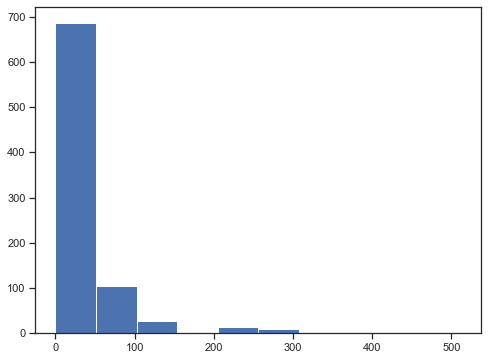

In [201]:
# distribution of values in numeric columns
plt.hist(df1['fare'])

print('Fare: minimum=', df1['fare'].min(), '; maximum=', df1['fare'].max(), '; median=', df1['fare'].median())
# zero fare is rather unexpected; how many passenger have zero fare?
print('Passengers with zero fare: ', (df1['fare']==0).sum())
print('The most often fares: ')
print(df1['fare'].value_counts().sort_values(ascending=False).iloc[0:5])

> Fare values seem to be valid with exception of zero fares.

Age: minimum= 0.1667 ; maximum= 80.0 ; median= 28.0
The most often ages:
18.0    32
30.0    30
24.0    29
22.0    28
25.0    26
Name: age, dtype: int64


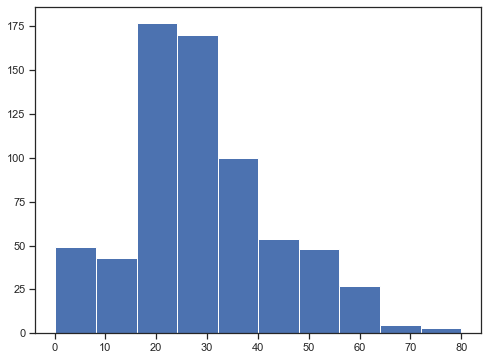

In [202]:
plt.hist(df1['age'])

print('Age: minimum=', df1['age'].min(), '; maximum=', df1['age'].max(), '; median=', df1['age'].median())
# zero fare is rather unexpected; how many passenger have zero fare?
print('The most often ages:')
print(df1['age'].value_counts().sort_values(ascending=False).iloc[0:5])

> Age values seem to be fully valid.

Let's check the **integrity of data for the ticket**.

* one ticket -- one fare?
* one ticket -- same class?
* one ticket -- same embarkment?
* one ticket -- cabins?

In [203]:
print(df1.groupby('ticket').agg({'fare': 'nunique'}).value_counts())
# Which ticket is for passenger with missing fare? Are there more passengers for this ticket?
ticket_na_fare = df1[df1['fare'].isna()]['ticket'].values.tolist()
df1[df1['ticket'].isin(ticket_na_fare)]

fare
1       659
0         1
dtype: int64


,passenger_id,ticket,pclass,fare,sex,age,cabin,embarked
416,1225,3701,3,NaN,male,60.5,NaN,S


In [204]:
print(df1.groupby('ticket').agg({'pclass': 'nunique'}).value_counts())

pclass
1         660
dtype: int64


In [205]:
print(df1.groupby('ticket').agg({'embarked': 'nunique'}).value_counts())
# For which ticket were there more embarkments?
tmp_tickets = df1.groupby('ticket').agg({'embarked': 'nunique'})
ticket_mult_emb = tmp_tickets[tmp_tickets['embarked'] > 1].index.tolist()
df1[df1['ticket'].isin(ticket_mult_emb)]

embarked
1           658
0             1
2             1
dtype: int64


,passenger_id,ticket,pclass,fare,sex,age,cabin,embarked
285,258,113798,1,31.0,female,30.0,NaN,C
381,46,113798,1,31.0,male,NaN,NaN,S


In [206]:
print(df1.groupby('ticket').agg({'cabin': 'nunique'}).value_counts())

cabin
0        532
1        112
2         14
3          1
4          1
dtype: int64


> For each ticket, there is same fare (possibly missing or zero) and same class.  
> For each ticket except two cases, there is same embarkment place. One ticket has two places and one ticket none (missing).  
> There can be various numbers of cabin for a ticket (and possibly none, too).

### Dealing with missing and invalid data

Now we use exploration outcomes for decision how to treat missing or invalid data.

**TASK 1. Consider following questions. Then clean data -- omit cases.**

* Should cases with missing fare be omitted?
* Should cases with zero fare be omitted?
* Should cases missing embarkment be omitted?
* Should cases with missing age be omitted?
* Should cases with missing cabin be omitted?

**Answers:**

* missing fare -- should be omitted (one case only)
* zero fare -- should be omitted (few cases only, possibly special ones or simply errors)
* missing embarkment -- should be omitted (one case only)
* missing age -- should not be omitted (too many cases, we have to deal with it other way)
* missing cabin -- should not be omitted (missing value is informative)

In [207]:
# TASK 1 cleaning
df1 = df1[df1['fare'].notna() & (df1['fare']>0) & (df1['embarked'].notna())]

### Making different entities -- tickets
We make a table of tickets by few steps:

1. Base table -- unique rows of *ticket*, *pclass*, *fare* (we now there is integrity).
2. Aggregated features grouped by *ticket* -- e. g. count of passengers; join aggregated table to the base table.
3. Artificial aggregation as a solution of multiple embarkment -- we take the highest value of *embarked* to unify embarkment places for tickets.

**TASK 2. Make a table with tickets as rows (650 rows) and (some aggregated) features. Choose useful features for future analysis by yourself.**

**Chosen features:**
* count of passengers
* ratio of male passengers
* age of the youngest and of the oldest passenger
* average age of passengers
* count af passengers with known age
* sex od the oldest passenger
* count of (distinct) cabins

In [208]:
# TASK 2 solution
# User function
def rate_males(s):
    return np.mean(np.where(s=='male', 1, 0))

### Base table
df2_base = df1[['ticket', 'pclass', 'fare']].drop_duplicates()
df2_base = df2_base.set_index('ticket') # setting 'ticket' column as key

### Multiple embarkment solution
df2_emb = df1.groupby('ticket').agg({'embarked': 'max'})
# print('Ticket with multiple embarkment has been unified:')
# print(df2_emb.loc['113798'])
# no need to set index - groupby + agg sets index by default

### Some chosen features
df2_feat = df1.groupby('ticket').agg({'ticket': 'count', 'sex': [rate_males],
                                      'age': ['min', 'max', np.mean, 'count'], 'cabin': 'nunique'})
# column names update
df2_feat.columns = ['pass_cnt', 'rate_males', 'age_min', 'age_max', 'age_mean', 'age_valid_cnt', 'cabin_cnt']

# sex of the oldest person for the ticket
df2_feat_sex_oldest = df1.sort_values(by=['ticket', 'age'], ascending=[True, False]) \
    .drop_duplicates('ticket')[['ticket', 'sex']]
df2_feat_sex_oldest = df2_feat_sex_oldest.set_index('ticket') # setting 'ticket' column as key
df2_feat_sex_oldest.columns = ['sex_oldest']

### Joining tables together
df2 = df2_base.join(df2_emb) # join is by default LEFT and index<->index
df2 = df2.join(df2_feat)
df2 = df2.join(df2_feat_sex_oldest)

### Mathematical transformations

* The distribution of fare is very skew. Let's transform it by log to get it better balanced.
* The fare is given as a total. But it's better to get an average fare per one passenger.

**TASK 3. Add new columns to the table as stated above.**

In [209]:
# Task 3 solution
df2['fare_log'] = np.log10(df2['fare']) # we use log10 for better interpretation, but simple log is ok, too.
df2['fare_per_pass'] = df2['fare'] / df2['pass_cnt']

### Feature extraction

* "binning" numeric values (making categories)
* making True/False flags
* combining multiple columns

**TASK 4.**
1. Make new columns as meaningful categories "binned" from count of passengers, mean age, count of distinct cabins.
2. Make flags "child" and "baby": flag is True when the youngest passenger for a ticket was under 15, resp. under 3 years.
3. Find the most often combinations of men and women travelling on one ticket (e. g. "single man", "man+woman", "two men", "other" etc.) and make a new column with category description.

In [ ]:
### Task 4.1 solution
# First, find proper breaks for binning; then make binning; then check frequencies

### pass_cnt
print(df2['pass_cnt'].value_counts())
# categories will be 1, 2, 3, 4+
df2['pass_cnt_cat'] = pd.cut(df2['pass_cnt'], [0, 1, 2, 3, 1000], labels=['1', '2', '3', '4+'])
print(df2['pass_cnt_cat'].value_counts())

### age_mean
plt.hist(df2['age_mean'])
# categories will be up to 15, 15-25, 25-40, 40+
df2['age_mean_cat'] = pd.cut(df2['age_mean'], [0, 15, 20, 25, 30, 40, 1000],
                             labels=['15-', '15-20', '20-25', '25-30', '30-40', '40+'])
print(df2['age_mean_cat'].value_counts().sort_index())

### cabin_cnt (same approach as pass_cnt)
print(df2['cabin_cnt'].value_counts())
# categories will be none, 1, 2+
df2['cabin_cnt_cat'] = pd.cut(df2['cabin_cnt'], [0, 1, 2, 1000], right=False, labels=['none', '1', '2+'])
print(df2['cabin_cnt_cat'].value_counts())


In [220]:
### Task 4.2 solution
df2['flag_child'] = (df2['age_min'] < 15)
df2['flag_baby'] = (df2['age_min'] < 3)

In [233]:
### Task 4.3 solution
# analyze frequencies of various combinations
pd.pivot_table(df2, values='fare', index=['pass_cnt_cat'], columns=['rate_males'], aggfunc=np.size)
# then make a new column
# very simple example - can be extended by nested np.where conditions
df2['group'] = np.where((df2['rate_males']==1) & (df2['pass_cnt']==1), 'Single man', 'Other')

## Home credit
This dataset contains Home Credit clients who got a loan. Each client (=row in the dataset) has plenty of data in columns. We are interested in the segmentation of client portfolio. Segmentation is a division the basic dataset into some well-defined segment, like "young single men", "old widow women living alone" etc.

The relevant columns are *days_birth*, *code_gender*, *cnt_children*, *cnt_fam_members*, *name_family_status*.

**TASK: look into data and try to find some big segments based on some features from the set of relevant columns. You may need to do some binning before.**

In [245]:
df_hc = pd.read_csv('application_train.csv')
df_hc.columns = df_hc.columns.str.lower()
df_hc = df_hc[['days_birth', 'code_gender', 'cnt_children', 'cnt_fam_members', 'name_family_status']]